In [27]:
# import
from scipy.io import loadmat
from typing import Callable, Optional
import torch
import numpy as np
from scipy.spatial.distance import pdist, squareform
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
# rand_state = 42
# np.random.seed(rand_state)
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [29]:

# data preprocess:
path = "/home/edabk/cuong/test_project/qm7.mat"
data = loadmat(path)
xyz = data["R"] # 7165 x 23 x 3 <batch,#node,xyz>
charge = data["Z"] # 7165 x 23 <batch,#node,charge_scalar_value>
couloub = data["X"] # 7165 x 23 x 23 <batch,#node,#node> (like the edge feature matrix)
energy = data["T"] # 1 x 7165 <energy_scalar_value,batch>

The number of nodes that have coordinate:  15
The number of nodes that have coordinate:  15
The number of nodes that have coordinate:  14


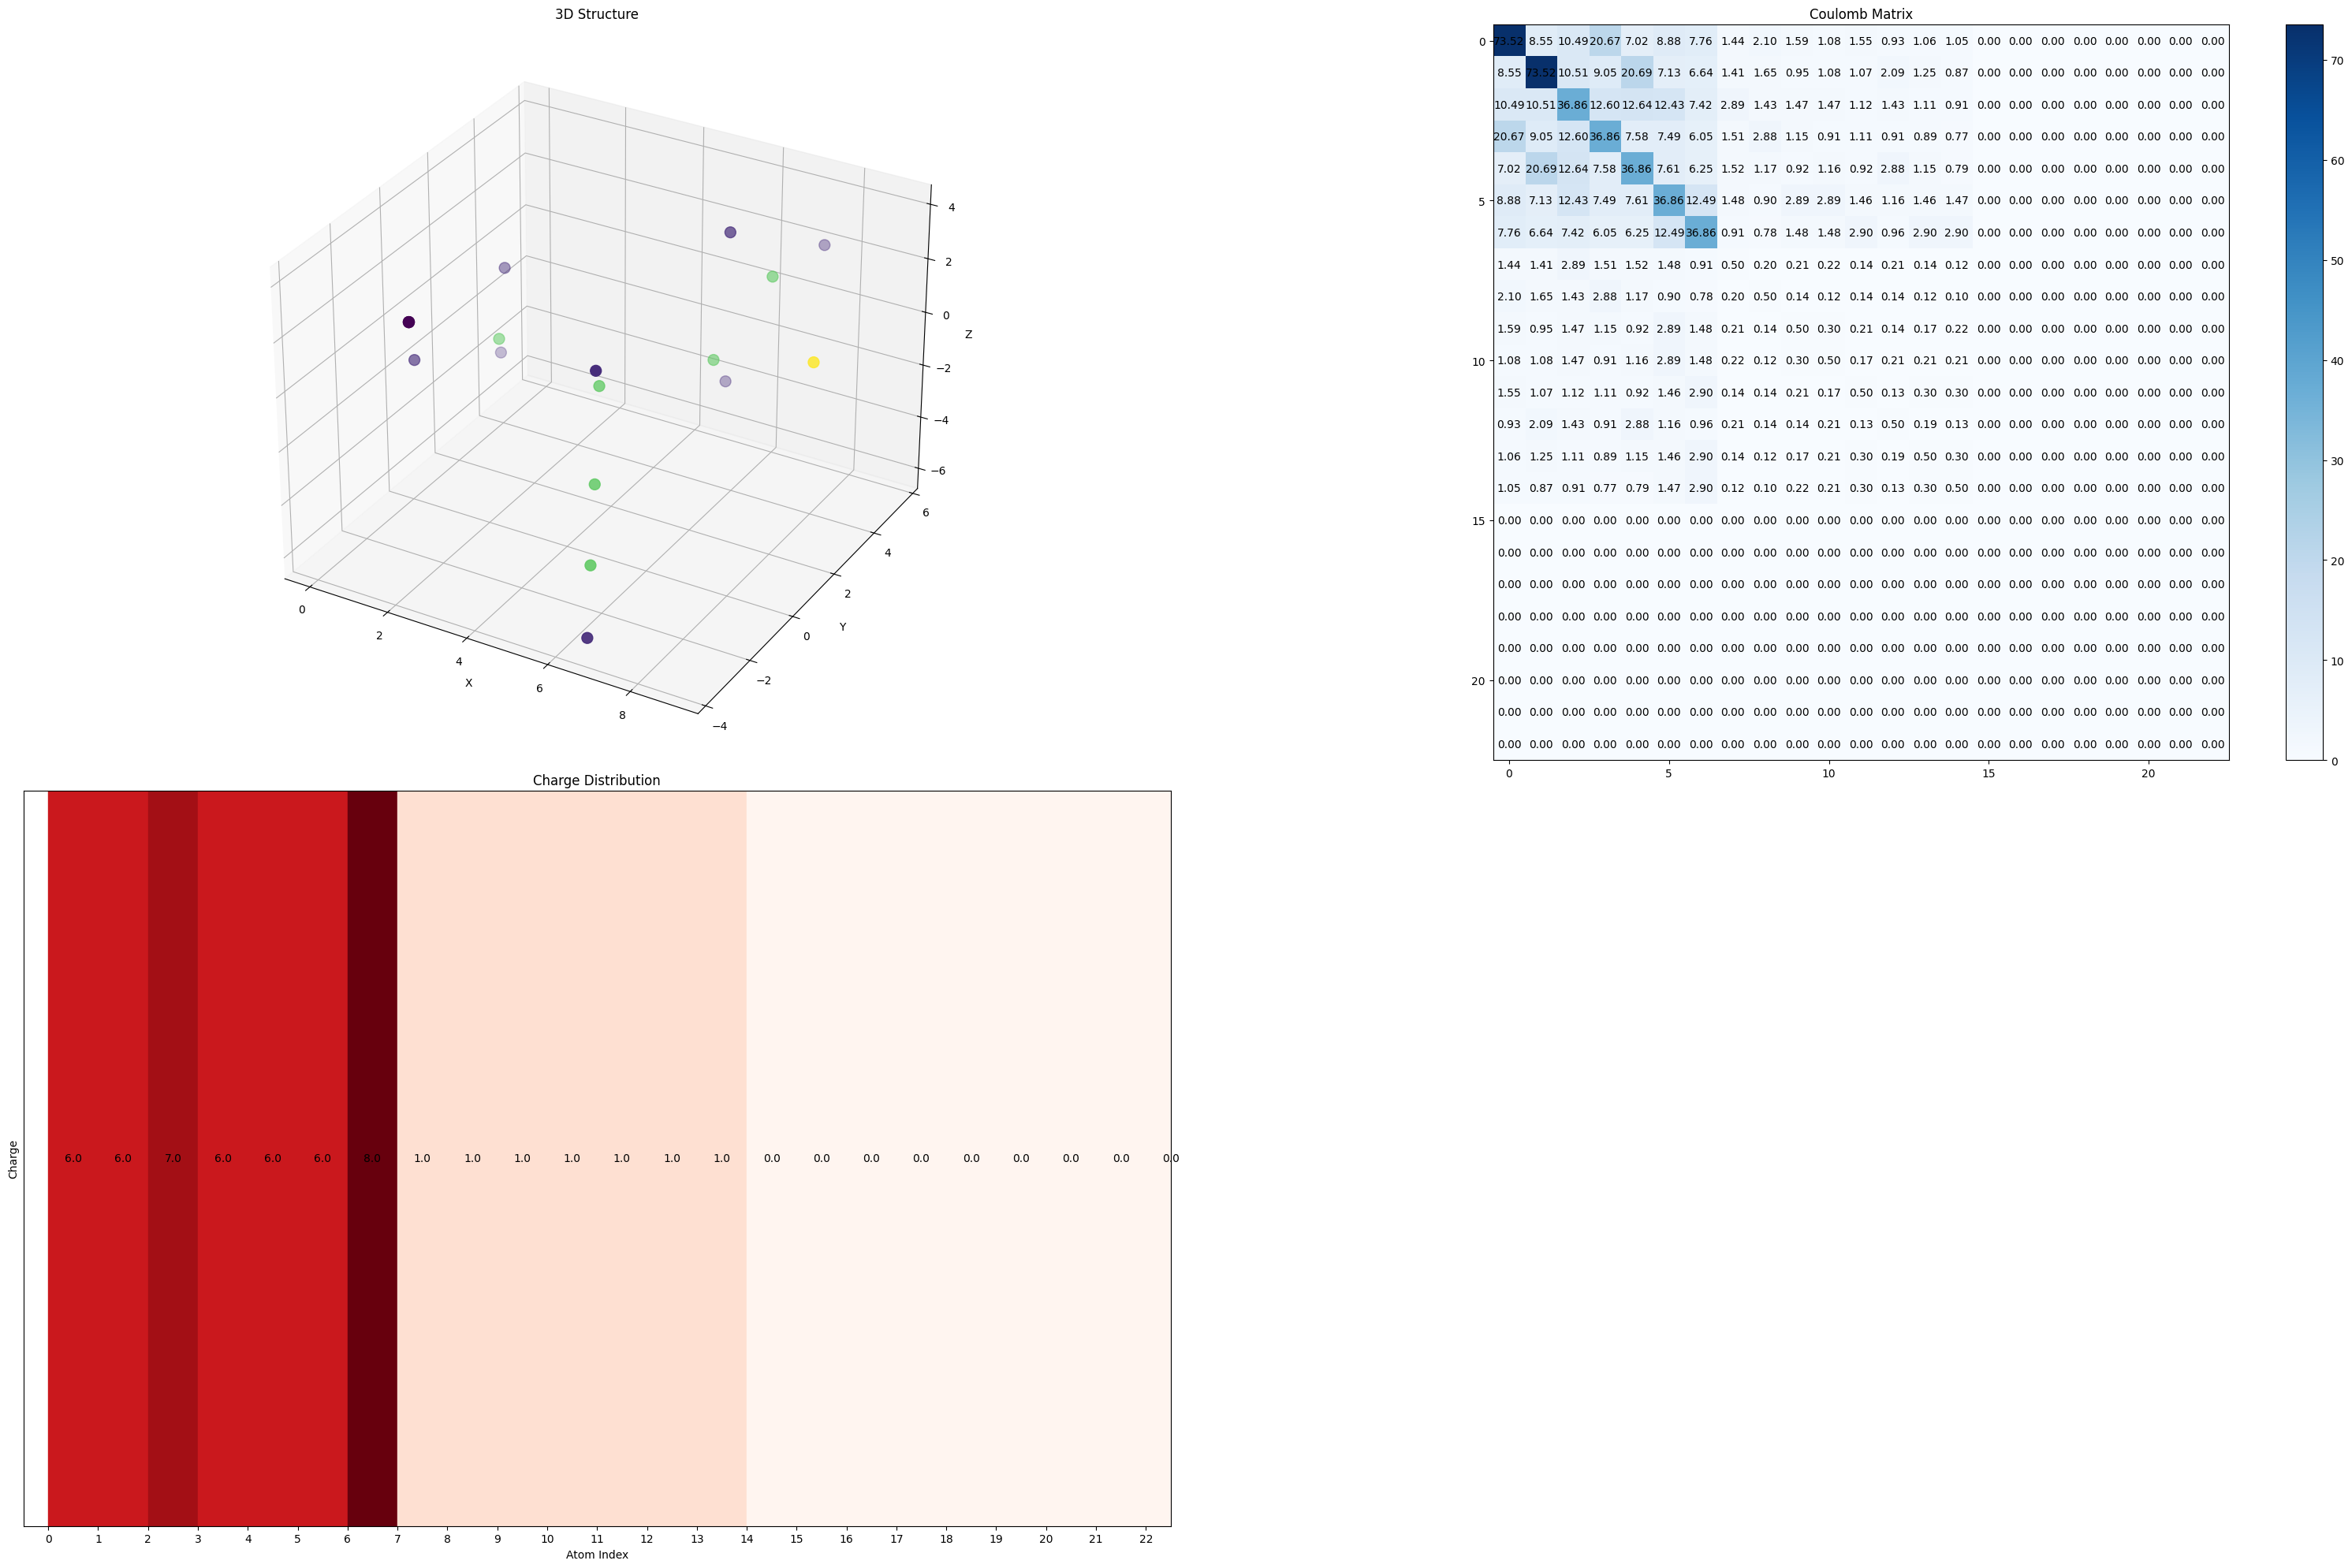

In [43]:
# Function to Create Individual Plots
def plot_data(ax, data, title, cmap=None):
    sample_idx = np.random.randint(len(xyz))  # Randomly select a sample
    num_visualizable = np.sum(np.any(xyz[sample_idx] != 0, axis=1))  # Count non-zero rows (nodes)
    print("The number of nodes that have coordinate: ",num_visualizable)
    if title == "3D Structure":
        ax.scatter(xyz[sample_idx,:,0], xyz[sample_idx,:,1], xyz[sample_idx,:,2], c=charge[sample_idx], cmap=cmap, s=100)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

    elif title == "Coulomb Matrix":
        cax = ax.imshow(couloub[sample_idx], cmap=cmap)
        plt.colorbar(cax, ax=ax, fraction=0.046)
        # Add text annotations
        for i in range(23):
            for j in range(23):
                ax.text(j, i, f'{couloub[sample_idx][i, j]:.2f}', ha='center', va='center', color='black', fontsize=10)

    elif title == "Charge Distribution":  # Updated for charge visualization
        charge_values = charge[sample_idx]
        # Create a colormap based on the range of charge values
        norm = plt.Normalize(charge_values.min(), charge_values.max())
        colors = cmap(norm(charge_values))

        # Create a grid with 1 row and 23 columns
        for i, charge_val in enumerate(charge_values):
            ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=colors[i]))
            ax.text(i + 0.5, 0.5, f'{charge_val:.1f}', ha='center', va='center',fontsize=10)  

        # Customize the plot appearance
        ax.set_xlim(-0.5, 22.5)
        ax.set_ylim(0, 1)
        ax.set_xticks(np.arange(23))
        ax.set_yticks([])
        ax.set_xlabel('Atom Index')

        
    ax.set_title(title)

# Create the Figure
fig = plt.figure(figsize=(30, 20))

# Create Subplots and Visualize
titles = ["3D Structure", "Coulomb Matrix", "Charge Distribution"]
cmaps = [cm.viridis, cm.Blues, cm.Reds]  # Different colormaps for each plot
# Create Subplots and Visualize
gs = fig.add_gridspec(1, 3, width_ratios=[1, 2, 1])  # Adjust width ratios to give the Coulomb matrix more space
# Explain :
# gs = fig.add_gridspec(1, 3, width_ratios=[1, 2, 1]) creates a grid specification with:
# 1 row and 3 columns.
# width_ratios=[1, 2, 1] means the Coulomb matrix subplot (middle column) will take up twice as much width as the other two subplots.

for i, (title, cmap) in enumerate(zip(titles, cmaps)):
    ax = fig.add_subplot(2, 2, i + 1, projection='3d' if title=="3D Structure" else None)
    if title == "Charge Distribution":
        plot_data(ax, charge, title, cmap=cmap)
        ax.set_xlabel('Atom Index')
        ax.set_ylabel('Charge')
    else:
        plot_data(ax, None, title, cmap=cmap)  # Data not needed for "Energy"

plt.tight_layout()
plt.show()

Preparation for Feature Extraction:

+ num_atoms = 23: Sets the number of atoms in the molecules.

+ iu = np.triu_indices(num_atoms, k=0): Generates indices for the upper triangle of a matrix (including diagonal). This is useful for dealing with symmetric pairwise relationships like distances.

+ iu_dist = np.triu_indices(num_atoms, k=1): Generates indices for the upper triangle excluding the diagonal (useful for pairwise distances without self-distances).

Feature Matrices Initialization:

+ CM: Coulomb matrix (to be filled later) representing electrostatic interactions within molecules.

+ eigs: Eigenvalues of distance matrices (related to molecular shape).

+ centralities: Eigenvector centralities (measures of node importance in a graph representation of the molecule).

+ interatomic_dist: Pairwise interatomic distances within molecules.

+ Iterate Over Molecules and Calculate Features:

+ Loop through each molecule's data (qm7['X']).

+ Extract the Coulomb matrix part (coulomb_vector) and sort it in descending order.

+ Calculate pairwise distances between atoms using squareform(pdist(R[i])).

+ Extract the upper triangle of the distance matrix to get dist_vector and sort it.

+ Calculate eigenvalues (w) and eigenvectors (v) of the distance matrix and sort them.

+ Calculate eigenvector centralities using the networkx library.

+ Store the calculated features in the respective matrices.

+ Print progress messages (if verbose is True).

Concatenate Features and Shape Output:


+ Combine all extracted feature matrices (CM, eigs, centralities, interatomic_dist) along columns (axis=1) into a single matrix X.

+ X.shape: Prints the dimensions of the final feature matrix, indicating the number of samples (molecules) and the total number of features extracted for each molecule.

Key Points

+ Coulomb Matrix: A way to represent molecular structure based on electrostatic interactions.

+ Eigenvalues and Centralities: Provide insights into molecular shape and the importance of individual atoms within the molecule's connectivity.

+ Pairwise Distances: Fundamental information about the relative positions of atoms in a molecule.


In [18]:
y = np.transpose(energy.reshape((7165,)))
y_scaling_factor = 2000.
y_scaled = y / y_scaling_factor

# k=0 # 0 = include diagnol, 1 = do not include diagnol

num_atoms = 23
iu = np.triu_indices(num_atoms,k=0) # default: Includes the main diagonal and everything above.
iu_dist = np.triu_indices(num_atoms,k=1) # for the pairwise distance matrix, all diagonol entries will be 0 
# What the np.triu_indices return?
# The first array contains the row indices of the upper triangle elements.
# The second array contains the corresponding column indices.

CM = np.zeros((couloub.shape[0], num_atoms*(num_atoms+1)//2), dtype=float) # shape 7165*276 (276 is the total number of upper triangular element in the 23 x 23 matrix)
eigs = np.zeros((couloub.shape[0], num_atoms), dtype=float)                # shape 7165*23
centralities = np.zeros((couloub.shape[0], num_atoms), dtype=float)        # shape 7165*23
interatomic_dist = np.zeros((couloub.shape[0], ((num_atoms*num_atoms)-num_atoms)//2), dtype=float)  # shape 7165*253 (276 is the total number of upper triangular element in the 23 x 23 matrix, excluding the diagonals (276-23))

verbose=True

for i, cm in enumerate(couloub): # loop through each sample
    coulomb_vector = cm[iu]  # choose only the upper triangular elements : 276
    # Sort elements by decreasing order
    shuffle = np.argsort(-coulomb_vector)
    CM[i] = coulomb_vector[shuffle] # the triu elements , sorted decressing: 276 : hold the in4 about the couloub value between 23 nodes (removed the redundant in4)
    dist = squareform(pdist(xyz[i])) # shape 23 * 23 , contain the pair-wise distance between the 23 nodes
    # we can extract the upper triangle of the distance matri: return vector of dimension (1,num_atoms)
    dist_vector = dist[iu_dist] # shape 253, since distance matrix are symmetric -> take only the upper triangular (276) -> since self-distance is meaningless, remove the diagonal -> 253
    shuffle = np.argsort(-dist_vector) 
    interatomic_dist[i] = dist_vector[shuffle] # still shape 253, holds the information about pair-wise distance of 23 nodes (removed the redundant in4)
    
    w,v = np.linalg.eig((dist)) # Eigenvalues (w): (23,) Represent how much a vector is stretched or shrunk when transformed by the distance matrix
                                # Eigenvectors (v): (23,23) These are vectors that, when multiplied by the distance matrix, only change in scale (stretched or shrunk) but not in direction
    eigs[i] = w[np.argsort(-w)]
    centralities[i] = np.array(list(nx.eigenvector_centrality(nx.Graph(dist)).values())) # (23,) , value from 0 -> 1
    """Explaination of centrailities
    Captures the relative importance of each atom in the molecule's connectivity structure. Atoms with high eigenvector centrality might:

    + Be central to the overall molecular shape.
    + Play crucial roles in chemical reactions or interactions.
    + Be important for understanding the molecule's properties and behavior.
    """
    if verbose and i % 500 == 0:
        print("Processed {} molecules".format(i))
    
X = np.concatenate((CM, eigs, centralities, interatomic_dist), axis=1) # (7165, 575) , where 575 = 276 + 23 + 23 + 253
X.shape

/tmp/ipykernel_3321061/692798093.py:34: ComplexWarning: Casting complex values to real discards the imaginary part
  eigs[i] = w[np.argsort(-w)]


Processed 0 molecules
Processed 500 molecules
Processed 1000 molecules
Processed 1500 molecules
Processed 2000 molecules
Processed 2500 molecules
Processed 3000 molecules
Processed 3500 molecules
Processed 4000 molecules
Processed 4500 molecules
Processed 5000 molecules
Processed 5500 molecules
Processed 6000 molecules
Processed 6500 molecules
Processed 7000 molecules


(7165, 575)

/home/edabk/anaconda3/envs/Sleep/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

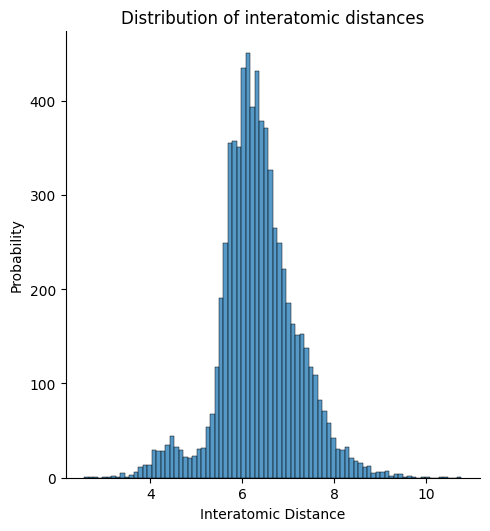

/home/edabk/anaconda3/envs/Sleep/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 800x600 with 0 Axes>

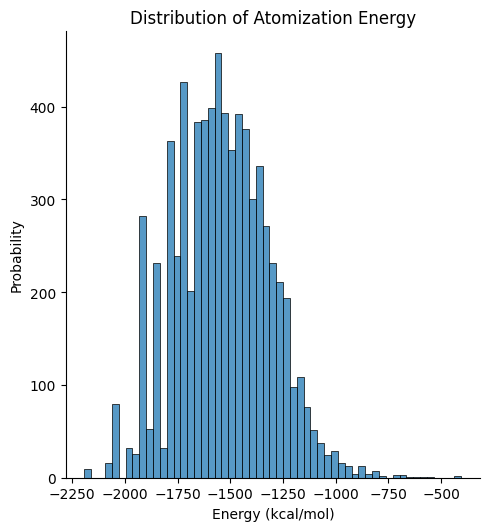

In [24]:
def mean_dist(x):
    x[x == 0] = np.nan
    return np.nanmean(x, axis=0)
mean_dists = np.apply_along_axis(mean_dist, axis=1, arr=interatomic_dist)
plt.figure(figsize=(8,6))
sns.displot(mean_dists)
plt.xlabel('Interatomic Distance')
plt.ylabel('Probability')
plt.title('Distribution of interatomic distances')
plt.show()

plt.figure(figsize=(8,6))
sns.displot(y)
plt.xlabel('Energy (kcal/mol)')
plt.ylabel('Probability')
plt.title('Distribution of Atomization Energy')
plt.show()